In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/kaggle/input/life-expectancy-who/Life Expectancy Data.csv")
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


# EDA:

In [2]:
print("DATA QUALITY:")
print("-" * 50)
print(" DATA SHAPE:\n")
print(f"-  {df.shape[0]} Rows\n-  {df.shape[1]} Columns\n")
print("   Columns:", list(df.columns))
print(" COMPLETENESS CHECK:\n")

# Completeness Check (Missing Values)
missing_values = df.isna().sum()[df.isnull().sum() > 0]
missing_percent = (missing_values / len(df)) * 100

# Combine missing count and percentage into a DataFrame
missing_data = pd.DataFrame({
    "Missing Values": missing_values,
    "Percent Missing": missing_percent
})
missing_data = missing_data[missing_data["Missing Values"] > 0]
print(missing_data)
print("\n")
print(" DATA TYPES AND ROW COUNTS:\n")
print(df.info())
print("\n")
print(" DATA STATISTICS:\n")
print(df.describe())

DATA QUALITY:
--------------------------------------------------
 DATA SHAPE:

-  2938 Rows
-  22 Columns

   Columns: ['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
 COMPLETENESS CHECK:

                                 Missing Values  Percent Missing
Life expectancy                              10         0.340368
Adult Mortality                              10         0.340368
Alcohol                                     194         6.603131
Hepatitis B                                 553        18.822328
 BMI                                         34         1.157250
Polio                                        19         0.646698
Total expenditure                           226 

## Data Cleaning and Preprocessing:

In [3]:
# Changing the column names into a universal format
df.columns = df.columns.str.strip()
df.columns = df.columns.str.lower()

## Missing values:

In [4]:
cols_miss = df.isnull().sum()[df.isnull().sum() > 0].index
cols_miss

Index(['life expectancy', 'adult mortality', 'alcohol', 'hepatitis b', 'bmi',
       'polio', 'total expenditure', 'diphtheria', 'gdp', 'population',
       'thinness  1-19 years', 'thinness 5-9 years',
       'income composition of resources', 'schooling'],
      dtype='object')

In [5]:
from sklearn.impute import SimpleImputer
imputer_num = SimpleImputer(strategy="mean")

for col in cols_miss:
    if df[col].dtype != "object":
        df[col] = imputer_num.fit_transform(df[[col]])
        print(f"{col} done")

life expectancy done
adult mortality done
alcohol done
hepatitis b done
bmi done
polio done
total expenditure done
diphtheria done
gdp done
population done
thinness  1-19 years done
thinness 5-9 years done
income composition of resources done
schooling done


## Categoricals

We have two categorical variables only: country and status and as a part of EDA we can do the following to have a general idea of what we're dealing with and to see which encoding method suits our case best:
- we check how many countries we have to see if there are any multiple appearances of certain countries
- we then check the unique values of status to see the frequency of each value

In [6]:
df['country'].nunique()

193

In [7]:
df.groupby("country").count()["year"].reset_index(name="country frequencies").groupby("country frequencies").count()

,country
country frequencies,
1,10
16,183


We have 193 unique countries, which is too many for a numerical encoding like Label or One-Hot encoding.

- Label encoding introduces an artificial order, which doesn't make sense for countries.
- Regression models will misinterpret the numbers, leading to poor performance

Our best option here is Target Encoding because it handles high-cardinality well and it captures meaningful relationships. 

In [8]:
# Compute mean life expectancy per country
country_means = df.groupby('country')['life expectancy'].mean()

# Replace country names with their corresponding mean life expectancy
df['country_encoded'] = df['country'].map(country_means)

In [9]:
df.groupby("status").count()["country"]

status
Developed      512
Developing    2426
Name: country, dtype: int64

As we can see we have a binary categorical column like, in thi cas both One-Hot encoding and label encoding are valid, it's just that since we are using Linear Regression OHE is way better:
- Label Encoding is generally better for tree-based models because these models are not affected by numerical ordering.
- Linear models might misinterpret label encoding as a numerical relationship (i.e., "Developed" is better than "Developing"), which can bias predictions.

=> so OHE it is...


In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
ohe = OneHotEncoder(drop="first",sparse_output=False)
df["status"] = ohe.fit_transform(df[["status"]])

## Correlation and colinearity:

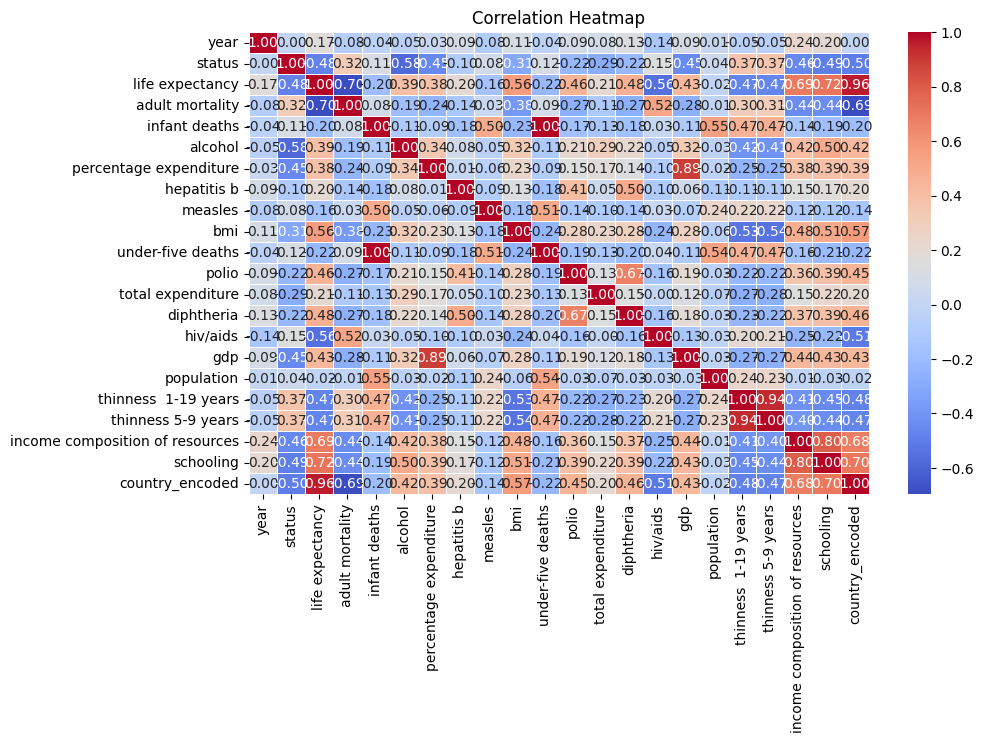

In [12]:
corr = df.drop(columns=["country"]).corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', 
linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Remarks:

- We notice some high colinearity between certain features, starting with:
    - infant deaths and under-five deaths, corr = 1.0 => redundancy, we drop under-five deaths.
    - Percentage expenditure and gdp with corr = 0.89 => redundancy, w drop percentage expenditure.
    - country_encoded and life expectancy (target variable) with corr = 0.96 => redundancy, we drop them both from the training set.


For the last pair, noticing this high correlation wasn't surprising since we only have two different country frequencies 1 and 16, this is more likely going to lead to high colinearity between the target variable and the encoded countries because 183 countries are going to have the mean of the target variable across 16 rows, and the other 10 are going to have the same target value for their rows.


In [13]:
X_simple = df[["schooling"]] # training set for simple regression
# trainig set for other regression techniques:
X = df.drop(columns=["life expectancy","country","country_encoded","under-five deaths","percentage expenditure"])

## Scaling features:

From the data statistics in EDA, we can notice some features with very large std's, meaning high dispersion in their data distributions and could imply the existance of outliers, for that we need to scale the features down to make the data distributions more balanced. 

In [14]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_simple_scaled = scaler.fit_transform(X_simple)

# Training:

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

## Simple regression:

In [16]:
y = df["life expectancy"]

X_train, X_test, y_train, y_test = train_test_split(X_simple_scaled, y, test_size=0.2, random_state=42)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Simple Linear Regression:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

Simple Linear Regression:
MSE: 39.37
R²: 0.55


## Multiple regression

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

multiple_linear_reg = LinearRegression()
multiple_linear_reg.fit(X_train, y_train)

y_pred = multiple_linear_reg.predict(X_test)

mse_multi = mean_squared_error(y_test, y_pred)
r2_multi = r2_score(y_test, y_pred)

print("\nMultiple Linear Regression:")
print(f"MSE: {mse_multi:.2f}")
print(f"R²: {r2_multi:.2f}")


Multiple Linear Regression:
MSE: 16.32
R²: 0.81


In [18]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

y_pred_poly = poly_reg.predict(X_test_poly)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("\nPolynomial Regression (Degree=2):")
print(f"MSE: {mse_poly:.2f}")
print(f"R²: {r2_poly:.2f}")


Polynomial Regression (Degree=2):
MSE: 7.86
R²: 0.91


In [19]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=10.0)  # Alpha controls the strength of regularization
ridge_reg.fit(X_train_poly, y_train)

y_pred_ridge = ridge_reg.predict(X_test_poly)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\nRidge Regression:")
print(f"MSE: {mse_ridge:.2f}")
print(f"R²: {r2_ridge:.2f}")


Ridge Regression:
MSE: 7.35
R²: 0.92


In [20]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Increase max_iter and keep alpha=0.1
lasso_reg = Lasso(alpha=0.01, max_iter=10000)
lasso_reg.fit(X_train_poly, y_train)

y_pred_lasso = lasso_reg.predict(X_test_poly)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\nLasso Regression:")
print(f"MSE: {mse_lasso:.2f}")
print(f"R²: {r2_lasso:.2f}")


Lasso Regression:
MSE: 7.18
R²: 0.92


In [21]:
from IPython.display import display, HTML
from tabulate import tabulate

def create_comparison_table(models, mse_values, r2_values, render_type='html'):
    """
    Creates a comparison table for regression models with MSE and R² metrics.
    """
    # Ensure inputs are of equal length
    if not (len(models) == len(mse_values) == len(r2_values)):
        raise ValueError("All input lists must have the same length.")
    
    # Create a DataFrame-like structure
    table_data = list(zip(models, mse_values, r2_values))
    headers = ["Model", "MSE", "R²"]
    
    if render_type.lower() == 'html':
        # Create HTML table
        html = "<table>\n<thead>\n<tr>"
        for header in headers:
            html += f"<th>{header}</th>"
        html += "</tr>\n</thead>\n<tbody>"
        
        for row in table_data:
            html += "\n<tr>"
            html += f"<td>{row[0]}</td>"  # Model
            html += f"<td>{row[1]:.2f}</td>"  # MSE
            html += f"<td>{row[2]:.2f}</td>"  # R²
            html += "</tr>"
        html += "\n</tbody>\n</table>"
        
        # Display in Jupyter notebook
        display(HTML(html))
    
    elif render_type.lower() == 'text':
        # Use tabulate for a clean console table
        print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=".2f"))
    
    else:
        raise ValueError("render_type must be 'html' or 'text'")


In [22]:
models = ["Simple Linear", "Multiple Linear", "Polynomial (Degree=2)", "Ridge", "Lasso"]
mse_values = [mse, mse_multi, mse_poly, mse_ridge, mse_lasso]
r2_values = [r2, r2_multi, r2_poly, r2_ridge, r2_lasso]

# Render as HTML (for Jupyter)
print("Comparison Table (HTML):")
create_comparison_table(models, mse_values, r2_values, render_type='html')

Comparison Table (HTML):


Model,MSE,R²
Simple Linear,39.37,0.55
Multiple Linear,16.32,0.81
Polynomial (Degree=2),7.86,0.91
Ridge,7.35,0.92
Lasso,7.18,0.92
